# Task 1

In [2]:
# set options for R markdown knitting
knitr::opts_chunk$set(echo = TRUE)
knitr::opts_chunk$set(linewidth=80)

In [3]:
# set up line wrapping in MD knit output
library(knitr)
hook_output = knit_hooks$get("output")
knit_hooks$set(output = function(x, options)
{
# this hook is used only when the linewidth option is not NULL
if (!is.null(n <- options$linewidth))
{
x = knitr:::split_lines(x)
# any lines wider than n should be wrapped
if (any(nchar(x) > n))
x = strwrap(x, width = n)
x = paste(x, collapse = "\n")
}
hook_output(x, options)
})

Load required libraries and datasets

In [4]:
#### Load required libraries
library(data.table)
library(ggplot2)
library(ggmosaic)
library(readr)


In [5]:
#file path  to read the data
filePath <- ""
transactionData <- fread(paste0(filePath,"QVI_transaction_data.csv"))
customerData <- fread(paste0(filePath,"QVI_purchase_behaviour.csv"))

In [6]:
head(data_behaiour)

ERROR: Error in head(data_behaiour): object 'data_behaiour' not found


## Exploratory data analysis

The first step in any analysis is to first understand the data. Let's take a look
at each of the datasets provided.

### Examining transaction data

We can use `str()` to look at the format of each column and see a sample of the
data. As we have read in the dataset as a `data.table` object, we can also run
`transactionData` in the console to see a sample of the data or use
`head(transactionData)` to look at the first 10 rows.

In [ ]:
str(transactionData)
head(transactionData)

Classes 'data.table' and 'data.frame':	264836 obs. of  8 variables:
 $ DATE          : int  43390 43599 43605 43329 43330 43604 43601 43601 43332 43330 ...
 $ STORE_NBR     : int  1 1 1 2 2 4 4 4 5 7 ...
 $ LYLTY_CARD_NBR: int  1000 1307 1343 2373 2426 4074 4149 4196 5026 7150 ...
 $ TXN_ID        : int  1 348 383 974 1038 2982 3333 3539 4525 6900 ...
 $ PROD_NBR      : int  5 66 61 69 108 57 16 24 42 52 ...
 $ PROD_NAME     : chr  "Natural Chip        Compny SeaSalt175g" "CCs Nacho Cheese    175g" "Smiths Crinkle Cut  Chips Chicken 170g" "Smiths Chip Thinly  S/Cream&Onion 175g" ...
 $ PROD_QTY      : int  2 3 2 5 3 1 1 1 1 2 ...
 $ TOT_SALES     : num  6 6.3 2.9 15 13.8 5.1 5.7 3.6 3.9 7.2 ...
 - attr(*, ".internal.selfref")=<externalptr> 


DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<dbl>
43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
43604,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1


In [ ]:
str(customerData)
head(customerData)

Classes 'data.table' and 'data.frame':	72637 obs. of  3 variables:
 $ LYLTY_CARD_NBR  : int  1000 1002 1003 1004 1005 1007 1009 1010 1011 1012 ...
 $ LIFESTAGE       : chr  "YOUNG SINGLES/COUPLES" "YOUNG SINGLES/COUPLES" "YOUNG FAMILIES" "OLDER SINGLES/COUPLES" ...
 $ PREMIUM_CUSTOMER: chr  "Premium" "Mainstream" "Budget" "Mainstream" ...
 - attr(*, ".internal.selfref")=<externalptr> 


LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
<int>,<chr>,<chr>
1000,YOUNG SINGLES/COUPLES,Premium
1002,YOUNG SINGLES/COUPLES,Mainstream
1003,YOUNG FAMILIES,Budget
1004,OLDER SINGLES/COUPLES,Mainstream
1005,MIDAGE SINGLES/COUPLES,Mainstream
1007,YOUNG SINGLES/COUPLES,Budget


In [25]:
#Convert DATE column to a date format
transactionData$DATE <- as.Date(transactionData$DATE, origin = "1899-12-30")

In [26]:
productWords <- data.table(unlist(strsplit(unique(transactionData[, PROD_NAME]), " ")))
setnames(productWords, 'words')
summary_prod_name <- table(transactionData$PROD_NAME)
print(summary_prod_name)


                       Burger Rings 220g 
                                    1564 
                CCs Nacho Cheese    175g 
                                    1498 
                       CCs Original 175g 
                                    1514 
                CCs Tasty Cheese    175g 
                                    1539 
          Cheetos Chs & Bacon Balls 190g 
                                    1479 
                      Cheetos Puffs 165g 
                                    1448 
                    Cheezels Cheese 330g 
                                    3149 
                Cheezels Cheese Box 125g 
                                    1454 
          Cobs Popd Sea Salt  Chips 110g 
                                    3265 
  Cobs Popd Sour Crm  &Chives Chips 110g 
                                    3159 
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g 
                                    3269 
        Dorito Corn Chp     Supreme 380g 
                                 

Looks like we are definitely looking at potato chips but how can we check that
these are all chips? We can do some basic text analysis by summarising the
individual words in the product name.

In [ ]:
productWords <- data.table(unlist(strsplit(unique(transactionData[, PROD_NAME]), " ")))
setnames(productWords, 'words')

Removing digits

In [ ]:
containsDigitsOrSpecial <- grepl("[0-9&]", productWords$words)
productWords <- productWords[!containsDigitsOrSpecial]

In [ ]:
wordFrequency <- table(productWords$words)
sortedWordFrequency <- data.table(words = names(wordFrequency), frequency = as.integer(wordFrequency))

# Remove rows with empty strings in the 'words' column
sortedWordFrequency <- sortedWordFrequency[words != ""]

# Sort by frequency in descending order
sortedWordFrequency <- sortedWordFrequency[order(-frequency)]

# Print or inspect the sorted word frequency
print(sortedWordFrequency)

       words frequency
  1:   Chips        21
  2:  Smiths        16
  3: Crinkle        14
  4:     Cut        14
  5:  Kettle        13
 ---                  
167:     Veg         1
168:  Vinegr         1
169:  Vingar         1
170: Whlegrn         1
171:  Whlgrn         1


There are salsa products in the dataset but we are only interested in the chips
category, so let's remove these.

In [7]:
transactionData[, SALSA := grepl("salsa", tolower(PROD_NAME))]
transactionData <- transactionData[SALSA == FALSE, ][, SALSA := NULL]

In [18]:
summary(transactionData)

      DATE         STORE_NBR     LYLTY_CARD_NBR        TXN_ID       
 Min.   :43282   Min.   :  1.0   Min.   :   1000   Min.   :      1  
 1st Qu.:43373   1st Qu.: 70.0   1st Qu.:  70015   1st Qu.:  67569  
 Median :43464   Median :130.0   Median : 130367   Median : 135182  
 Mean   :43464   Mean   :135.1   Mean   : 135530   Mean   : 135130  
 3rd Qu.:43555   3rd Qu.:203.0   3rd Qu.: 203083   3rd Qu.: 202652  
 Max.   :43646   Max.   :272.0   Max.   :2373711   Max.   :2415841  
    PROD_NBR       PROD_NAME            PROD_QTY       TOT_SALES     
 Min.   :  1.00   Length:246740      Min.   :1.000   Min.   : 1.700  
 1st Qu.: 26.00   Class :character   1st Qu.:2.000   1st Qu.: 5.800  
 Median : 53.00   Mode  :character   Median :2.000   Median : 7.400  
 Mean   : 56.35                      Mean   :1.906   Mean   : 7.316  
 3rd Qu.: 87.00                      3rd Qu.:2.000   3rd Qu.: 8.800  
 Max.   :114.00                      Max.   :5.000   Max.   :29.500  

In [19]:
outlier <- transactionData[PROD_QTY == 200,]
outlier

DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<dbl>


In [20]:
outlierTransactions <- transactionData[LYLTY_CARD_NBR == 226000,] # this is the outliers customer
outlierTransactions

DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<dbl>


In [21]:
transactionData <- transactionData[LYLTY_CARD_NBR != 226000]

In [15]:
print(transactionData)

         DATE STORE_NBR LYLTY_CARD_NBR TXN_ID PROD_NBR
     1: 43390         1           1000      1        5
     2: 43599         1           1307    348       66
     3: 43605         1           1343    383       61
     4: 43329         2           2373    974       69
     5: 43330         2           2426   1038      108
    ---                                               
246736: 43533       272         272319 270088       89
246737: 43325       272         272358 270154       74
246738: 43410       272         272379 270187       51
246739: 43461       272         272379 270188       42
246740: 43365       272         272380 270189       74
                                       PROD_NAME PROD_QTY TOT_SALES
     1:   Natural Chip        Compny SeaSalt175g        2       6.0
     2:                 CCs Nacho Cheese    175g        3       6.3
     3:   Smiths Crinkle Cut  Chips Chicken 170g        2       2.9
     4:   Smiths Chip Thinly  S/Cream&Onion 175g        5      15.0


In [23]:
productWords <- data.table(unlist(strsplit(unique(transactionData[, PROD_NAME]), " ")))
setnames(productWords, 'words')
containsDigitsOrSpecial <- grepl("[0-9&]", productWords$words)
productWords <- productWords[!containsDigitsOrSpecial]
wordFrequency <- table(productWords$words)
sortedWordFrequency <- data.table(words = names(wordFrequency), frequency = as.integer(wordFrequency))

sortedWordFrequency <- sortedWordFrequency[words != ""]

sortedWordFrequency <- sortedWordFrequency[order(-frequency)]

print(sortedWordFrequency)

          words frequency
  1:      Chips        21
  2:     Smiths        15
  3:    Crinkle        13
  4:        Cut        13
  5:     Kettle        13
 ---                     
155:     Vinegr         1
156:     Vingar         1
157:    Whlegrn         1
158:     Whlgrn         1
159: Woolworths         1


In [27]:
transactions_by_date <- transactionData[, .N, by = DATE]
print(transactions_by_date)

           DATE   N
  1: 2018-10-17 682
  2: 2019-05-14 705
  3: 2019-05-20 707
  4: 2018-08-17 663
  5: 2018-08-18 683
 ---               
360: 2018-12-08 622
361: 2019-01-30 689
362: 2019-02-09 671
363: 2018-08-31 658
364: 2019-02-12 684


In [32]:
summary(transactions_by_date)

      DATE                  N        
 Min.   :2018-07-01   Min.   :607.0  
 1st Qu.:2018-09-29   1st Qu.:658.0  
 Median :2018-12-30   Median :674.0  
 Mean   :2018-12-30   Mean   :677.9  
 3rd Qu.:2019-03-31   3rd Qu.:694.2  
 Max.   :2019-06-30   Max.   :865.0  

There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's
create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a
chart of number of transactions over time to find the missing date.

In [39]:
date_sequence <- data.table(DATE = seq(as.Date("2018-07-01"), as.Date("2019-06-30"), by = "days"))
transactions_by_day <- merge(date_sequence, transactions_by_date, by = "DATE", all.x = TRUE)
transactions_by_day[is.na(N), N := 0]
print(transactions_by_day)

           DATE   N
  1: 2018-07-01 663
  2: 2018-07-02 650
  3: 2018-07-03 674
  4: 2018-07-04 669
  5: 2018-07-05 660
 ---               
361: 2019-06-26 657
362: 2019-06-27 669
363: 2019-06-28 673
364: 2019-06-29 703
365: 2019-06-30 704


In [40]:
theme_set(theme_bw())
theme_update(plot.title = element_text(hjust = 0.5))


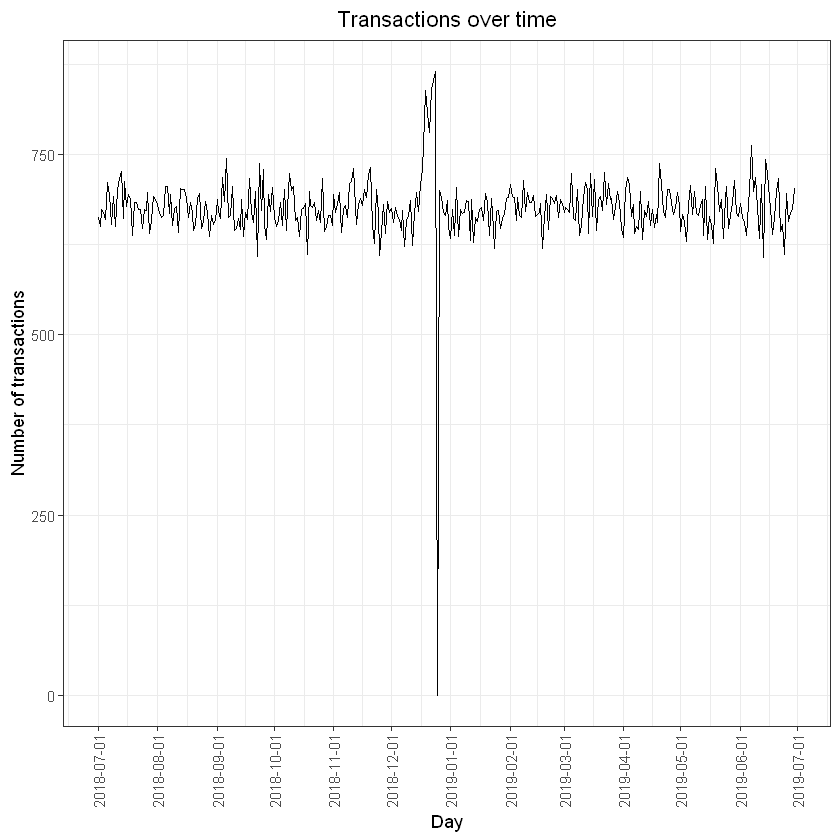

In [41]:
ggplot(transactions_by_day, aes(x = DATE, y = N)) + geom_line() + labs(x = "Day", y = "Number of transactions", title = "Transactions over time") + scale_x_date(breaks = "1 month") + theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

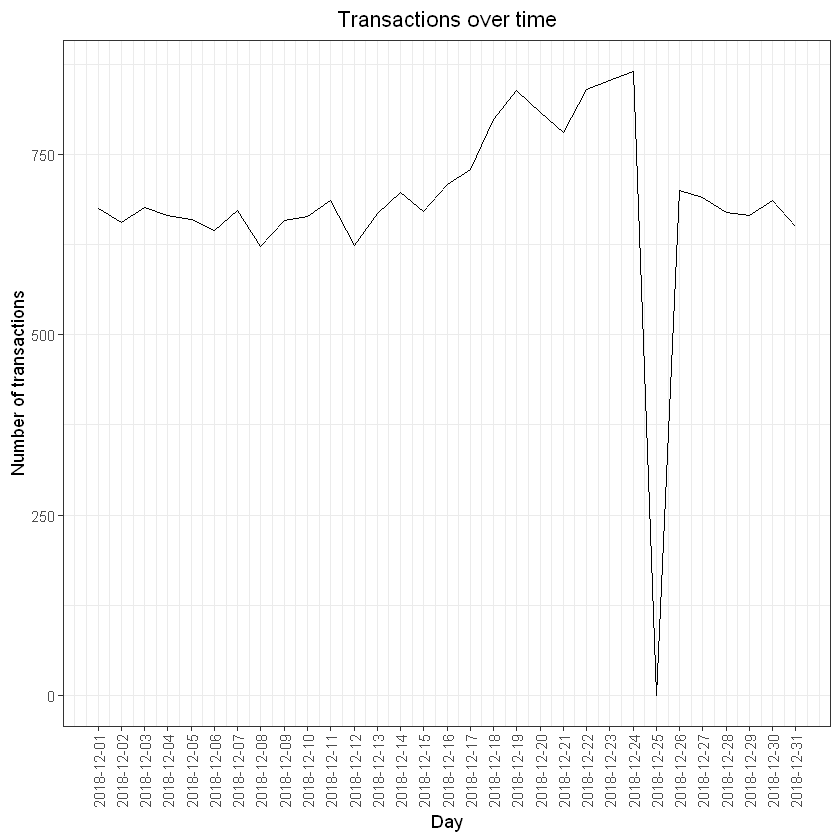

In [48]:
december_data <- transactions_by_day[month(DATE) == 12]

# Plot transactions over time with denser auxiliary lines
ggplot(december_data, aes(x = DATE, y = N)) +
  geom_line() +
  labs(x = "Day", y = "Number of transactions", title = "Transactions over time") +
  scale_x_date(breaks = seq(as.Date("2018-12-01"), as.Date("2018-12-31"), by = "1 day")) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

In [49]:
transactionData[, PACK_SIZE := parse_number(PROD_NAME)]

#### Always check your output
#### Let's check if the pack sizes look sensible
transactionData[, .N, PACK_SIZE][order(PACK_SIZE)]


PACK_SIZE,N
<dbl>,<int>
70,1507
90,3008
110,22387
125,1454
134,25102
135,3257
150,40203
160,2970
165,15297


Plot a histogram showing the number of transactions by pack size.

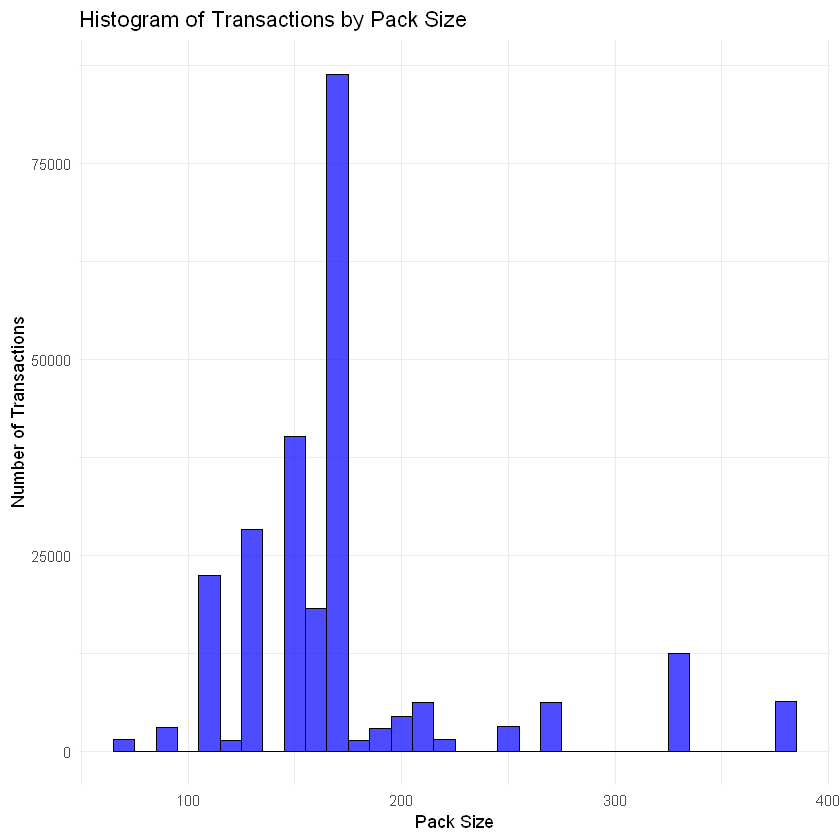

In [50]:
ggplot(transactionData, aes(x = PACK_SIZE)) +
  geom_histogram(binwidth = 10, fill = "blue", color = "black", alpha = 0.7) +
  labs(x = "Pack Size", y = "Number of Transactions", title = "Histogram of Transactions by Pack Size") +
  theme_minimal()

In [51]:
transactionData[, BRAND := gsub("^(\\w+).*", "\\1", PROD_NAME)]

# Checking the results
head(transactionData)

DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
<date>,<int>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>
2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural
2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs
2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths
2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths
2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle
2019-05-16,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7,330,Smiths


### Examining customer data

 LYLTY_CARD_NBR     LIFESTAGE         PREMIUM_CUSTOMER  
 Min.   :   1000   Length:72637       Length:72637      
 1st Qu.:  66202   Class :character   Class :character  
 Median : 134040   Mode  :character   Mode  :character  
 Mean   : 136186                                        
 3rd Qu.: 203375                                        
 Max.   :2373711                                        

[1] 0

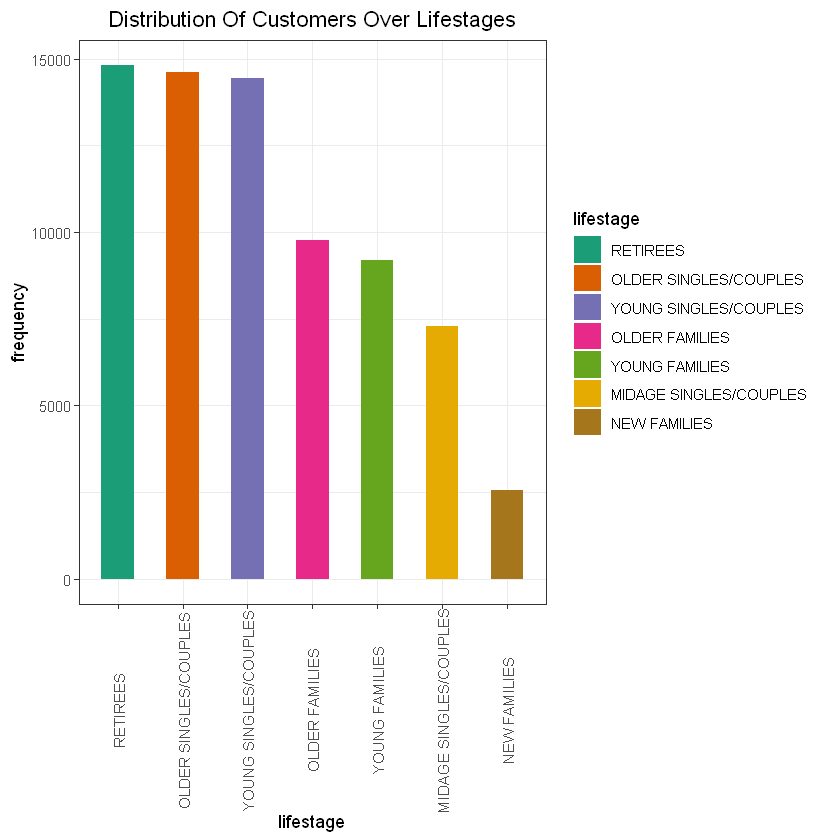

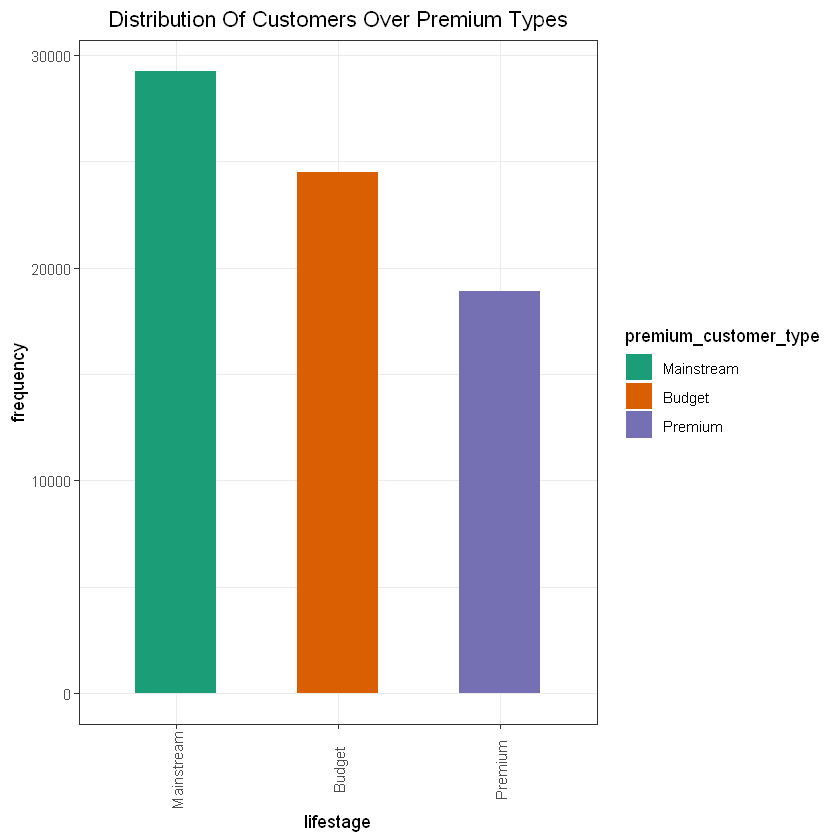

In [52]:
summary(customerData)
sum(is.na(customerData))
lifestageCategory <- data.frame(sort(table(customerData$LIFESTAGE),decreasing = TRUE ))

setnames(lifestageCategory,c("lifestage","freq"))

ggplot(lifestageCategory,aes(x=lifestage,y= freq,fill=lifestage)) +
  geom_bar(stat="identity",width = 0.5) + 
  labs(x = "lifestage", y ="frequency",title="Distribution Of Customers Over Lifestages")+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))+scale_fill_brewer(palette="Dark2")



premiumCustomerType <- data.frame(sort(table(customerData$PREMIUM_CUSTOMER),decreasing = TRUE ))

setnames(premiumCustomerType,c("premium_customer_type","freq"))

ggplot(premiumCustomerType,aes(x=premium_customer_type,y= freq,fill=premium_customer_type)) +
  geom_bar(stat="identity",width = 0.5) + 
  labs(x = "lifestage", y ="frequency",title="Distribution Of Customers Over Premium Types")+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))+scale_fill_brewer(palette="Dark2")

In [54]:
data <- merge(transactionData, customerData, all.x = TRUE)
sum(is.na(data))

[1] 0

In [55]:
fwrite(data, paste0(filePath,"QVI_data.csv"))

## Data analysis on customer segments

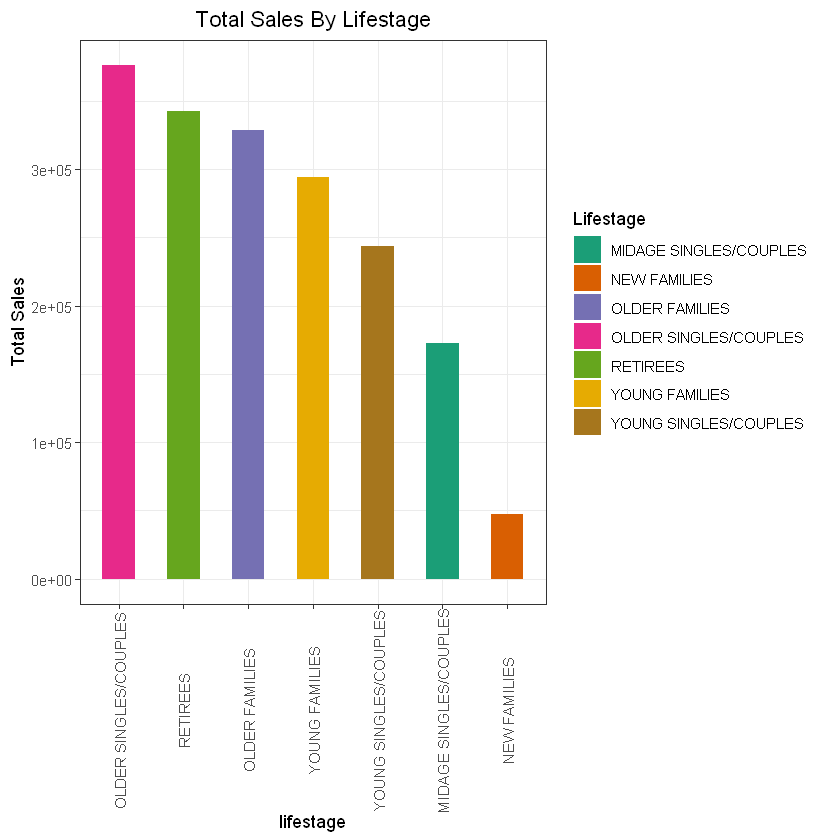

In [56]:
totalSalesByLifestage <- aggregate(data$TOT_SALES, by=list(LIFESTAGE=data$LIFESTAGE),FUN=sum)

setnames(totalSalesByLifestage,c("Lifestage","Total_Sales"))

totalSalesByLifestage<-totalSalesByLifestage[order(totalSalesByLifestage$Total_Sales,decreasing = FALSE),]

ggplot(totalSalesByLifestage,aes(x=reorder(Lifestage,-Total_Sales),y= Total_Sales,fill=Lifestage)) +
  geom_bar(stat="identity",width = 0.5) + 
  labs(x = "lifestage", y ="Total Sales",title="Total Sales By Lifestage")+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))+scale_fill_brewer(palette="Dark2")

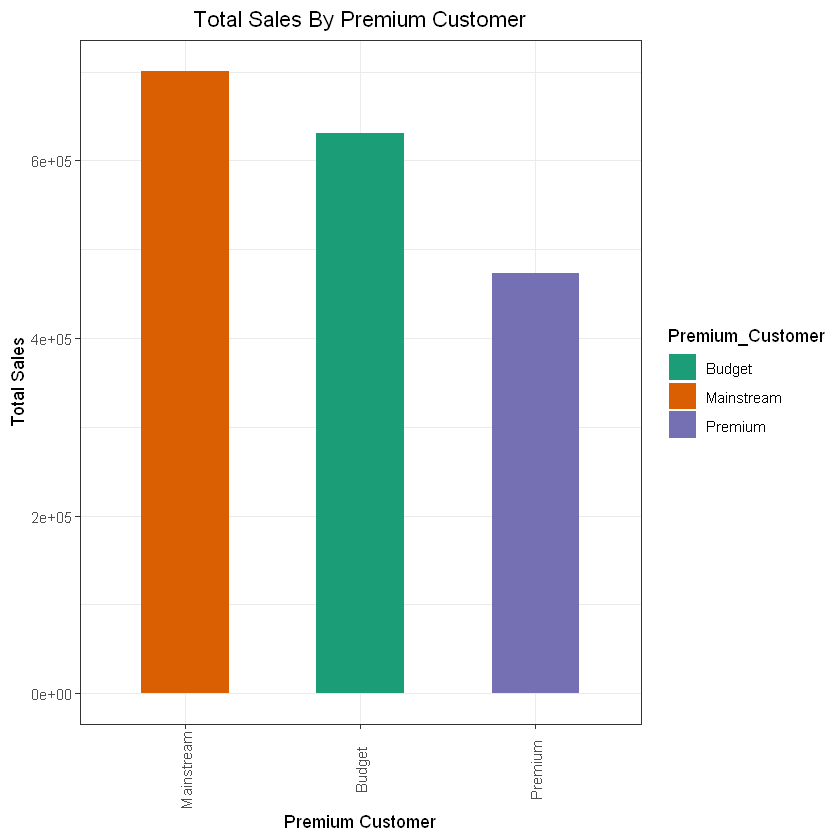

In [57]:
totalSalesByPremium <- aggregate(data$TOT_SALES, by=list(LIFESTAGE=data$PREMIUM_CUSTOMER),FUN=sum)

setnames(totalSalesByPremium,c("Premium_Customer","Total_Sales"))

totalSalesByPremium<-totalSalesByPremium[order(totalSalesByPremium$Total_Sales,decreasing = FALSE),]

ggplot(totalSalesByPremium,aes(x=reorder(Premium_Customer,-Total_Sales),y= Total_Sales,fill=Premium_Customer)) +
  geom_bar(stat="identity",width = 0.5) + 
  labs(x = "Premium Customer", y ="Total Sales",title="Total Sales By Premium Customer")+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))+scale_fill_brewer(palette="Dark2")

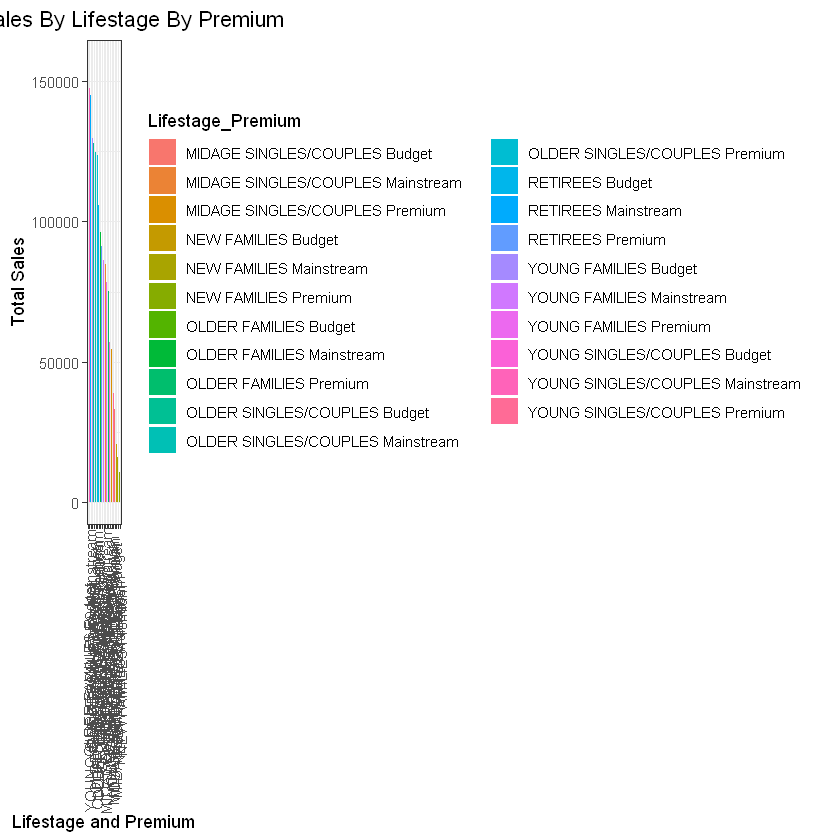

In [58]:
totalSalesByPremiumAndLifestage <- aggregate(.~LIFESTAGE+PREMIUM_CUSTOMER, data = data[,c("LIFESTAGE","PREMIUM_CUSTOMER","TOT_SALES")] , sum)


totalSalesByPremiumAndLifestage$Lifestage_Premium <- paste(totalSalesByPremiumAndLifestage$LIFESTAGE,totalSalesByPremiumAndLifestage$PREMIUM_CUSTOMER)
totalSalesByPremiumAndLifestage <- totalSalesByPremiumAndLifestage[,c("Lifestage_Premium","TOT_SALES")]

ggplot(totalSalesByPremiumAndLifestage,aes(x=reorder(Lifestage_Premium,-TOT_SALES),y= TOT_SALES,fill=Lifestage_Premium)) +
  geom_bar(stat="identity",width = 0.5) + 
  labs(x = "Lifestage and Premium", y ="Total Sales",title="Total Sales By Lifestage By Premium")+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

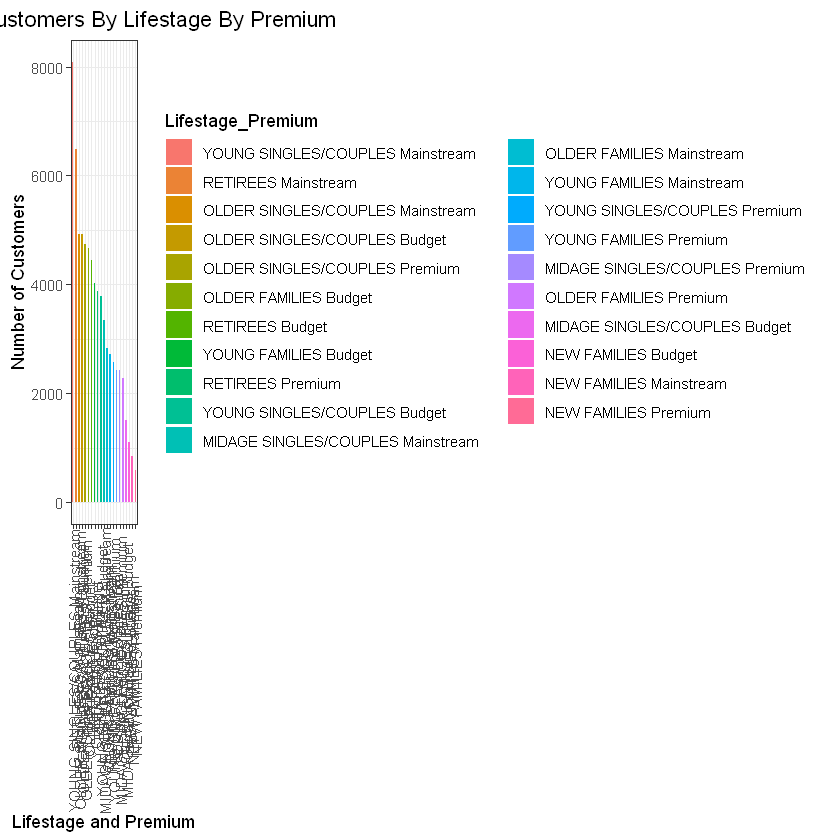

In [59]:
numberOfCustomersByLifestageByPremium <- data.frame(paste(customerData$LIFESTAGE,customerData$PREMIUM_CUSTOMER))


numberOfCustomersByLifestageByPremium <- data.frame(sort(table(numberOfCustomersByLifestageByPremium),decreasing = TRUE ))

setnames(numberOfCustomersByLifestageByPremium,c("Lifestage_Premium","freq"))

ggplot(numberOfCustomersByLifestageByPremium,aes(x=Lifestage_Premium,y = freq,fill=Lifestage_Premium)) +
  geom_bar(stat="identity",width = 0.5) + 
  labs(x = "Lifestage and Premium", y ="Number of Customers",title="Number of Customers By Lifestage By Premium")+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

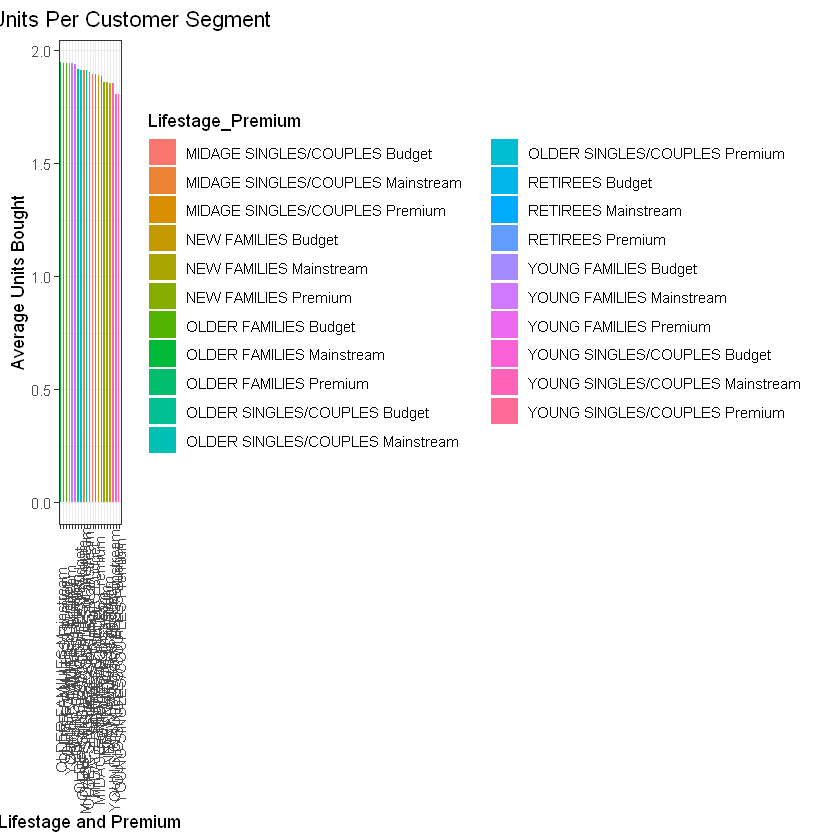

In [60]:
averageNumberOfUnits <- data.table(data[,c("LIFESTAGE","PREMIUM_CUSTOMER","PROD_QTY")])

averageNumberOfUnits$Lifestage_Premium <-  data.table(paste(data$LIFESTAGE,data$PREMIUM_CUSTOMER))

setnames(averageNumberOfUnits,c("Lifestage","premium","prod_qty","Lifestage_Premium"))


averageNumberOfUnits<- averageNumberOfUnits[,c("Lifestage_Premium","prod_qty")]


setnames(averageNumberOfUnits,c("Lifestage_Premium","PROD_QTY"))

averageNumberOfUnits <- aggregate(.~Lifestage_Premium, data = averageNumberOfUnits[,c("Lifestage_Premium","PROD_QTY")] , mean)

ggplot(averageNumberOfUnits,aes(x=reorder(Lifestage_Premium,-PROD_QTY),y= PROD_QTY,fill=Lifestage_Premium)) +
  geom_bar(stat="identity",width = 0.5) + 
  labs(x = "Lifestage and Premium", y ="Average Units Bought",title="Average Units Per Customer Segment ")+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

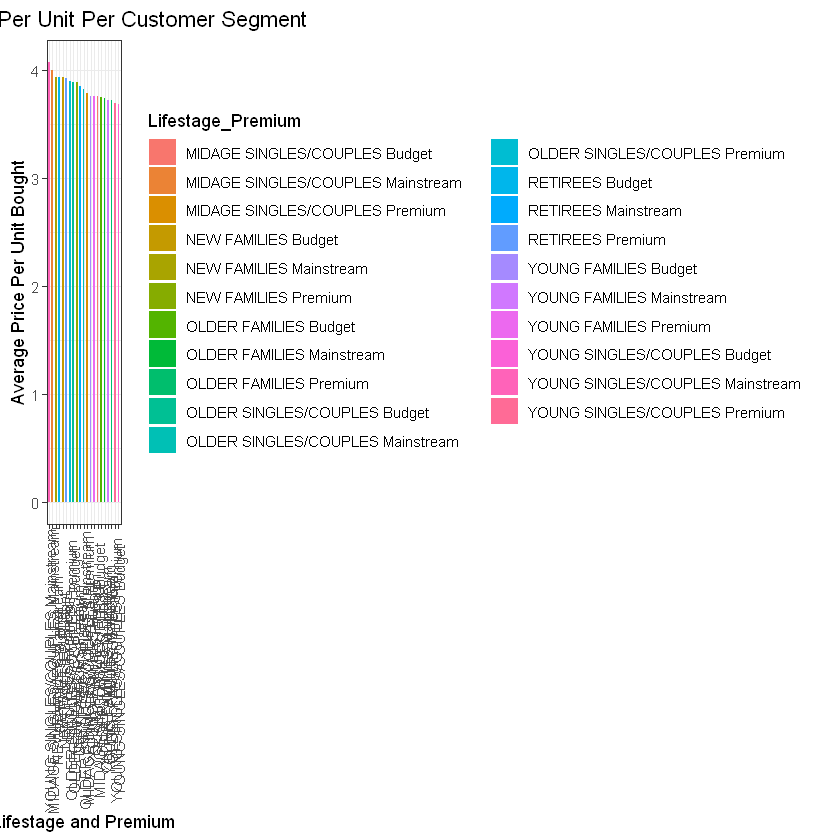

In [61]:
averagePrice <- data.table(data[,c("LIFESTAGE","PREMIUM_CUSTOMER","PROD_QTY","TOT_SALES")])

averagePrice$Lifestage_Premium <-  data.table(paste(data$LIFESTAGE,data$PREMIUM_CUSTOMER))

setnames(averagePrice,c("Lifestage","premium","prod_qty","TOT_SALES","Lifestage_Premium"))


averagePrice<- averagePrice[,c("Lifestage_Premium","prod_qty","TOT_SALES")]




averagePrice <- aggregate(.~Lifestage_Premium, data = averagePrice , FUN= sum )

averagePrice$averagePricePerUnit <- averagePrice$TOT_SALES / averagePrice$prod_qty


ggplot(averagePrice,aes(x=reorder(Lifestage_Premium,-averagePricePerUnit),y= averagePricePerUnit,fill=Lifestage_Premium)) +
  geom_bar(stat="identity",width = 0.5) + 
  labs(x = "Lifestage and Premium", y ="Average Price Per Unit Bought",title="Average Price Per Unit Per Customer Segment ")+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

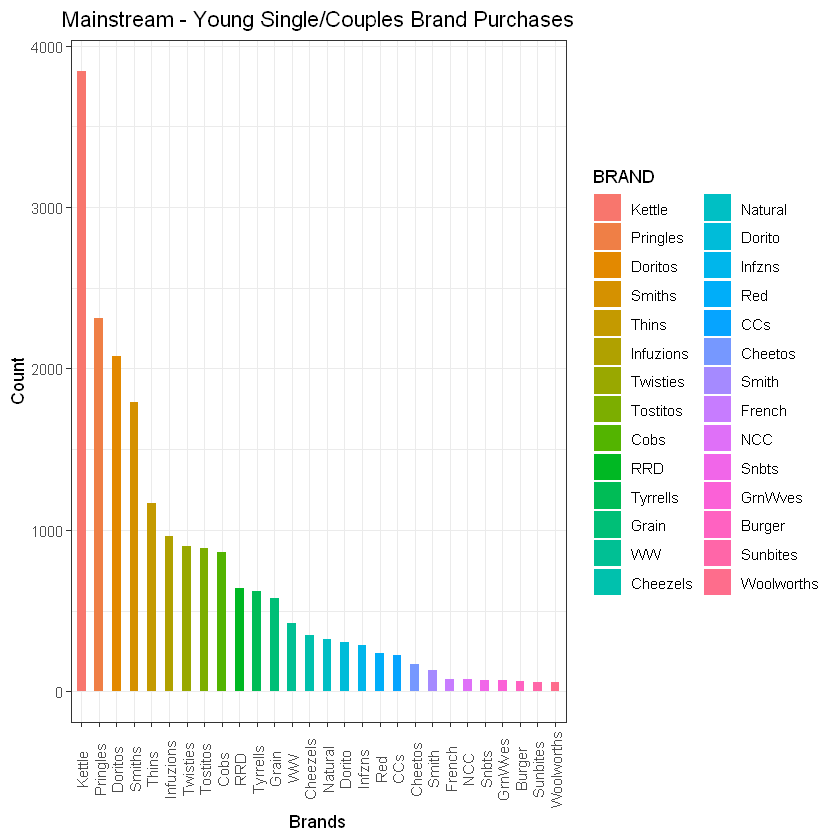

In [62]:
mainstreamYoungSingleCouples <- data.table(data)

mainstreamYoungSingleCouples$Lifestage_Premium <- data.table(paste(data$LIFESTAGE, data$PREMIUM_CUSTOMER))

mainstreamYoungSingleCouples <- mainstreamYoungSingleCouples[Lifestage_Premium == 'YOUNG SINGLES/COUPLES Mainstream']

mainstreamYoungSingleCouplesBrandFreq <- data.frame(sort(table(mainstreamYoungSingleCouples$BRAND), decreasing = TRUE))

setnames(mainstreamYoungSingleCouplesBrandFreq, c('BRAND', 'freq'))

ggplot(mainstreamYoungSingleCouplesBrandFreq, aes(x = BRAND, y = freq, fill = BRAND)) +
  geom_bar(stat = "identity", width = 0.5) +
  labs(x = "Brands", y = "Count", title = "Mainstream - Young Single/Couples Brand Purchases") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,Lifestage_Premium
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


[1] 178.3442

[1] 63.91625

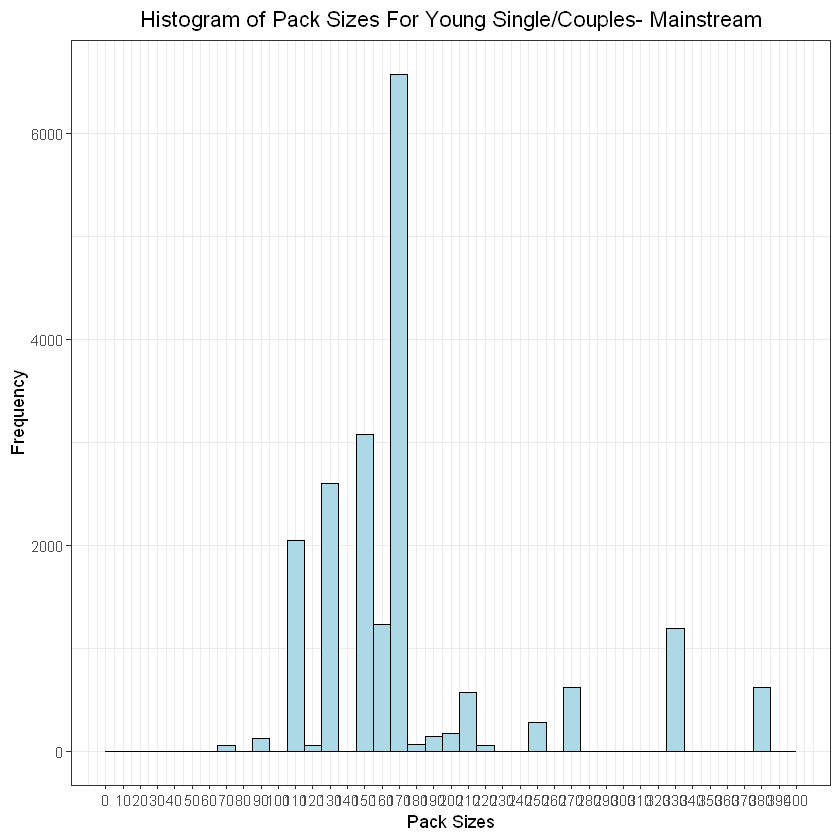

In [63]:
is.na(mainstreamYoungSingleCouples)

ggplot(mainstreamYoungSingleCouples,aes(x=PACK_SIZE) )+
  geom_histogram(binwidth = 10,color="black",fill="lightblue") +
  labs(x = "Pack Sizes", y ="Frequency",title="Histogram of Pack Sizes For Young Single/Couples- Mainstream")+scale_color_brewer(palette="Dark2")+geom_density(alpha=.2, fill="#FF6666")+
  scale_x_continuous(breaks = seq(0, 400, 10), limits = c(0,400))
# calculating mean and sd for pack size for this segment
mean(mainstreamYoungSingleCouples$PACK_SIZE)
sd(mainstreamYoungSingleCouples$PACK_SIZE)

In [64]:
segment1 <- data[LIFESTAGE == "YOUNG SINGLES/COUPLES" & PREMIUM_CUSTOMER == "Mainstream",]
other <- data[!(LIFESTAGE == "YOUNG SINGLES/COUPLES" & PREMIUM_CUSTOMER == "Mainstream"),]
quantity_segment1 <- segment1[, sum(PROD_QTY)]
quantity_other <- other[, sum(PROD_QTY)]
quantity_other_by_size <- other[, .(other = sum(PROD_QTY)/quantity_other), by = PACK_SIZE]

quantity_segment1_by_pack <- segment1[, .(targetSegment = sum(PROD_QTY)/quantity_segment1), by = PACK_SIZE]
quantity_other_by_pack <- other[, .(other = sum(PROD_QTY)/quantity_other), by = PACK_SIZE]
pack_proportions <- merge(quantity_segment1_by_pack, quantity_other_by_pack)[, affinityToPack := targetSegment/other]
pack_proportions[order(-affinityToPack)]

PACK_SIZE,targetSegment,other,affinityToPack
<dbl>,<dbl>,<dbl>,<dbl>
270,0.031828847,0.025095929,1.2682873
380,0.032160110,0.025584213,1.2570295
330,0.061283644,0.050161917,1.2217166
134,0.119420290,0.100634769,1.1866703
110,0.106280193,0.089791190,1.1836372
210,0.029123533,0.025121265,1.1593180
135,0.014768806,0.013075403,1.1295106
250,0.014354727,0.012780590,1.1231662
170,0.080772947,0.080985964,0.9973697


The main user groups of the sale are: budget shoppers and mainstream shoppers.

1.  Budget shoppers are mainly older households: they are characterized by being more budget conscious. However, they buy more frequently and in larger quantities. Promotional activities can help to increase the purchasing power of this group.

2.  Mainstream shoppers are mainly young people and retirees. These two groups had the highest total spending. This means that these groups are more willing to pay for crisps.

3.  In all the products Kettle is the most popular brand.